<a href="https://colab.research.google.com/github/LuisKolb/MachineLearningWS21/blob/main/ex3-moviereviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Reviews Classification with DL
adapted from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification_with_hub.ipynb

In [1]:
# if running in colab uncomment the following:

#!pip install tensorflow-hub
#!pip install tensorflow-datasets

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
# This might be necessary if runiing locally, depending on your machine's hardware

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [4]:
# Split the training set into 60% and 40% to end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRU2GY/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRU2GY/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteZRU2GY/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(512)))
#train_examples_batch
#train_labels_batch

In [25]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
#hub_layer(train_examples_batch[:3])

In [30]:
# helper functions

def epoch_plots(history):
  plt.figure(figsize =(5,3))
  plt.plot(history.history['loss'], marker='.', label='train')
  plt.plot(history.history['val_loss'], marker='.', label='validation')
  plt.title('Loss')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize =(5,3))
  plt.plot(history.history['accuracy'], marker='.', label='train')
  plt.plot(history.history['val_accuracy'], marker='.', label='validation')
  plt.title('Accuracy')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(loc='best')
  plt.show()

## Basic Models
These are very basic Layer designs to get a baseline reading before further tuning.

### CNN

In [21]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 7s 186ms/step - loss: 0.3606 - accuracy: 0.8702 - val_loss: 0.3166 - val_accuracy: 0.8799
Epoch 2/10
30/30 [==============================] - 6s 179ms/step - loss: 0.1343 - accuracy: 0.9807 - val_loss: 0.2661 - val_accuracy: 0.8856
Epoch 3/10
30/30 [==

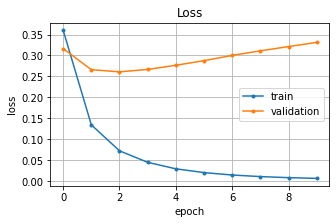

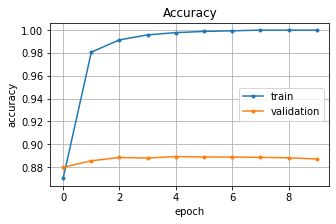

In [22]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['accuracy'], marker='.', label='train')
plt.plot(history.history['val_accuracy'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# depending on your GPU-RAM you might need to clear the model out of memory to avoid OOM-errors
del model

### RNN

In [14]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((128, 1)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 reshape_1 (Reshape)         (None, 128, 1)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,643,857
Trainable params: 124,643,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 9s 209ms/step - loss: 0.6806 - accuracy: 0.5007 - val_loss: 0.6675 - val_accuracy: 0.4990
Epoch 2/10
30/30 [============

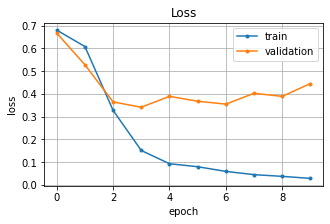

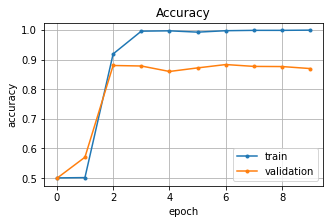

In [20]:
plt.figure(figsize =(5,3))
plt.plot(history.history['loss'], marker='.', label='train')
plt.plot(history.history['val_loss'], marker='.', label='validation')
plt.title('Loss')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize =(5,3))
plt.plot(history.history['accuracy'], marker='.', label='train')
plt.plot(history.history['val_accuracy'], marker='.', label='validation')
plt.title('Accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
del model

We get about **0.85 to 0.87 acurracy** with just very basic networks. Let's see if we can do a little better.

## Fine-tuned Networks

In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

### CNN
Here we add a dropout layer to avoid overfitting.

In [28]:
model = tf.keras.Sequential()
model.add(hub_layer)

model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation = "sigmoid"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,645,041
Trainable params: 124,645,04

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Epoch 1/4
30/30 [==============================] - 7s 184ms/step - loss: 0.0253 - accuracy: 0.9938 - val_loss: 0.4219 - val_accuracy: 0.8865
Epoch 2/4
30/30 [==============================] - 6s 179ms/step - loss: 0.0177 - accuracy: 0.9956 - val_loss: 0.4631 - val_accuracy: 0.8871
Epoch 3/4
30/30 [==============================] - 6s 177ms/step - loss: 0.0100 - accuracy: 0.9977 - val_loss: 0.5084 - val_accuracy: 0.8866
Epoch 4/4
30/30 [==============================] - 6s 176ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 0.5453 - val_accuracy: 0.8865
49/49 - 3s - loss: 0.6067 - accuracy: 0.8697 - 3s/epoch - 64ms/step
loss: 0.607
accuracy: 0.870


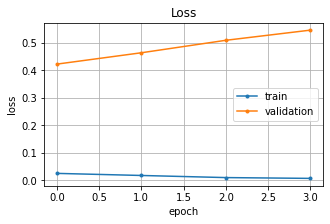

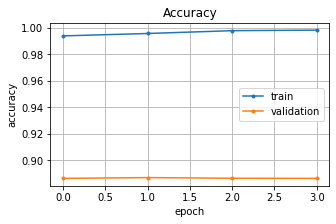

In [33]:
epoch_plots(history)

In [34]:
del model

### RNN

In [42]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Reshape((128, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_6 (Reshape)         (None, 128, 1)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 128, 128)         33792     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)              

Epoch 1/10
30/30 [==============================] - 19s 364ms/step - loss: 0.4864 - accuracy: 0.6853 - val_loss: 0.4256 - val_accuracy: 0.8463
Epoch 2/10
30/30 [==============================] - 10s 298ms/step - loss: 0.1225 - accuracy: 0.9666 - val_loss: 0.4151 - val_accuracy: 0.8722
Epoch 3/10
30/30 [==============================] - 10s 300ms/step - loss: 0.0502 - accuracy: 0.9877 - val_loss: 0.5205 - val_accuracy: 0.8706
Epoch 4/10
30/30 [==============================] - 10s 302ms/step - loss: 0.0239 - accuracy: 0.9952 - val_loss: 0.5963 - val_accuracy: 0.8724
Epoch 5/10
30/30 [==============================] - 10s 297ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.6828 - val_accuracy: 0.8707
Epoch 6/10
30/30 [==============================] - 10s 297ms/step - loss: 0.0045 - accuracy: 0.9993 - val_loss: 0.9014 - val_accuracy: 0.8690
Epoch 7/10
30/30 [==============================] - 10s 298ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.7821 - val_accuracy: 0.8605

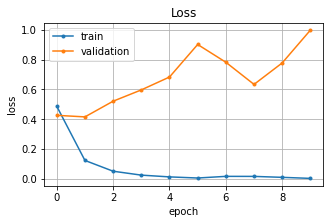

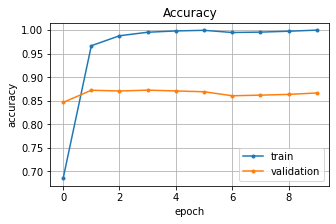

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))
epoch_plots(history)